# Read an hourly ASTRAL PSL ME2 mean meteorology file
## containing radiometer, sea snake, pressure

In [1]:
# usings

using Pkg; Pkg.activate(".")
using Dates
using Printf
using PyPlot

  Activating project at `~/Projects/ASTRAL/mast`


In [2]:
# general PSL DAS readers

# utility functions
m2n(x) = ismissing(x) ? NaN : x
pd = permutedims

# parameters for ASTRAL - feed defaults to functions
baseyear = 2024
mastdir = "./data/PSL/"
ncolumn = 22 # change for different file types

"yearday from Date or DateTime"
yday(dt) = Dates.value(Date(dt) - Date(year(dt)-1,12,31))
yday(ddd::String) = parse(Int, ddd)

"return all filenames with prefix and date dt"
function get_das_filenames(prefix, yd::Integer, mastdir=mastdir)
    filter(startswith(prefix), 
           readdir(joinpath(mastdir, @sprintf("%03d",yd))))
end
function get_das_filenames(prefix, dt::Date, mastdir=mastdir)
    get_das_filenames(prefix, yday(dt), mastdir)
end
"return filenames with prefix matching hour of dt"
function get_das_filenames(prefix, dt::DateTime, mastdir=mastdir)
    hh = @sprintf("%02d", Dates.value(Hour(dt)))
    filter( endswith(hh*"_raw.txt"),
            get_das_filenames(prefix, Date(dt), mastdir) )
end

"return vector of full paths of all files with prefix and date"
function get_das_pathfiles(prefix, dt, mastdir=mastdir)
    joinpath.(mastdir,
              @sprintf("%03d",yday(dt)),
              get_das_filenames(prefix, dt, mastdir))
end

"Convert a PSL date to a DateTime."
function psldatetime(d::Date, hr::Integer, psltime::String)
    mm  = Minute(     parse(Int32, psltime[1:2]))
    SS  = Second(     parse(Int32, psltime[3:4]))
    sss = Millisecond(parse(Int32, psltime[5:7]))
    DateTime(Date(d)) + Hour(hr) + mm + SS + sss
end
function psldatetime(d::Date, hr::Integer=0, minute::Real=0)
    DateTime(Date(d)) + Hour(hr) + Minute(minute) + Second(second)
end
function psldatetime(yearday::Integer, hr::Integer=0; minute::Real=0, year=baseyear)
    DateTime(year,12,31) + Day(yearday) + Hour(hr) + Minute(minute)
end
# psldatetime(Date(2024,5,8), hr, "0606111")
# To get filename from the date, hour
# psldatefile(prefix, psldatetime(d, hr, psltime))

# file format default parameters
nheader = 1
# dt = DateTime(2024,5,8,11,0,0)
# pathfilename = get_das_pathfiles(prefix, dt::DateTime, mastdir=mastdir)

"read das data and put in a dictionary"
function read_das_dict(pathfilename, keys;
    nheader=nheader,
    nsample=countlines(pathfilename) - nheader,
    ncolumn=length(keys) )

    # read data from file
    datatime, X = read_das_data(pathfilename; 
        nheader=nheader,
        nsample=countlines(pathfilename) - nheader,
        ncolumn=length(keys) )
    
    return das_dict(keys, datatime, X) # returns dict
end

"read das file data"
function read_das_data(pathfilename;
    nheader=nheader,
    nsample=countlines(pathfilename) - nheader,
    ncolumn=ncolumn )

    # preallocate the data
    psltime = Vector{String}(undef, nsample) # will point to data as it is read
    X = Array{Union{Float32,Missing}, 2}(undef, nsample, ncolumn-1)
    fill!(X, missing)

    open(pathfilename) do file
        for _ in 1:nheader
            readline(file) # skip header
        end
        nl = 0
        for line in readlines(file)
            nl += 1
            splt = split(line, [' ',',','\t'])
            psltime[nl] = splt[1]
            dataline = parse.(Float32, splt[2:end])
            nx = min(ncolumn, length(dataline))
            X[nl,1:nx] .= dataline[1:nx]
        end
    end

    # find hour from the filename
    shortfilename = last(splitpath(pathfilename))
    ddd = shortfilename[end-12:end-10]
    basedt = Date(baseyear-1,12,31) + Day(yday(ddd))
    hr = parse(Int32, shortfilename[end-9:end-8])
    psldt = psldatetime.(basedt, hr, psltime)
    return psldt, X
end

# concatentate the data like this
# X = cat(X1,X2, dims=1)
# dt = cat(dt1,dt2, dims=1)
"read and concatenate data from multiple files"
function read_das_dict(pathfilenames::Vector{String}, keys;
    nheader=nheader,
    nsample=sum( countlines.(pathfilenames) ),
    ncolumn=length(keys) )
    
    dt = Vector{DateTime}(undef, nsample)
    X  = Array{Union{Float32,Missing}, 2}(undef, nsample, length(keys)-1)
    
    # append data for each station
    nl = 0
    for pfn in pathfilenames
        tdt,tX = read_das_data(pfn)
        count = length(tdt)
        dt[nl+1:nl+count  ]   .= tdt
        X[ nl+1:nl+count,:] .=  tX
        nl += count
    end
    return das_dict(keys, dt[1:nl], X[1:nl,:])
end

# Dicts are just mutable groups bound to data.
# Data in dictionaries don't need to be allocated.

"assign data to a dict of keys"
function das_dict(keys, datatime, X)
    D = Dict{eltype(keys), Any}()

    # special DateTime
    D[keys[1]] = datatime 
    # fill rest of dictionary
    for (ik, ky) in enumerate(keys[2:end])
        D[ky] = X[:, ik]
    end
    return D
end

das_dict

In [3]:
# define keys for me2 format
me2keys = Symbol.(split(
    """time
    Batt_Volt
    PTemp
    Case1_R
    Case1_T
    Dome1_R
    Dome1_T
    Case2_R
    Case2_T
    Dome2_R
    Dome2_T
    PIR1_V
    PIR1_wm2
    PSP1_V
    PSP1_wm2
    PIR2_V
    PIR2_wm2
    PSP2_V
    PSP2_wm2
    Snake_R
    Snake_C
    BP_hpa"""))

22-element Vector{Symbol}:
 :time
 :Batt_Volt
 :PTemp
 :Case1_R
 :Case1_T
 :Dome1_R
 :Dome1_T
 :Case2_R
 :Case2_T
 :Dome2_R
 :Dome2_T
 :PIR1_V
 :PIR1_wm2
 :PSP1_V
 :PSP1_wm2
 :PIR2_V
 :PIR2_wm2
 :PSP2_V
 :PSP2_wm2
 :Snake_R
 :Snake_C
 :BP_hpa

In [4]:
#= read and plot an example file

mastdir = "./data/PSL/"
prefix = "me2"
dt = Date(2024,05,08) # for datestamp in filter(startswith("2024"), readdir(mastdir))
# get_das_pathfiles(prefix, dt)
pathfilename = get_das_pathfiles(prefix, dt)[1]
# filter(startswith("me2"), readdir(joinpath(mastdir, string(yday(dt)))))[1]

datatime, X = read_das_data(pathfilename; ncolumn=length(me2keys))
Me2 = read_das_dict(pathfilename, me2keys)

Vkey = filter(x -> endswith(String(x), "_V")    , me2keys)
Tkey = filter(x -> endswith(String(x), r"_T|_C"), me2keys)
Wkey = filter(x -> endswith(String(x), "_wm2"  ), me2keys)

# quick plot 1 hour
clf()
subplot(2,2,1)
for k in Tkey
    plot(m2n.(Me2[k]))
end
plot(m2n.(Me2[:PTemp]))
title("temperature")
legend((String.(Tkey)..., "PTemp"))

subplot(2,2,2)
plot(m2n.(Me2[:BP_hpa]))
title("pressure")
# legend("BP_hpa")

subplot(2,2,3)
for k in Wkey
    plot(m2n.(Me2[k]))
end
title("W/m2")
legend((String.(Wkey)))

subplot(2,2,4)
for k in Vkey
    plot(m2n.(Me2[k]))
end
title("voltage")
legend((String.(Vkey)))

tight_layout()
=#

In [9]:
function decimal_hour(dt::DateTime)::Float64
    hour = Dates.hour(dt)
    minute = Dates.minute(dt)
    second = Dates.second(dt)
    millisecond = Dates.millisecond(dt)
    
    # Calculate the decimal hour
    decimal_hour = hour + minute / 60 + second / 3600 + millisecond / 3600000
    return decimal_hour
end

decimal_hour (generic function with 1 method)

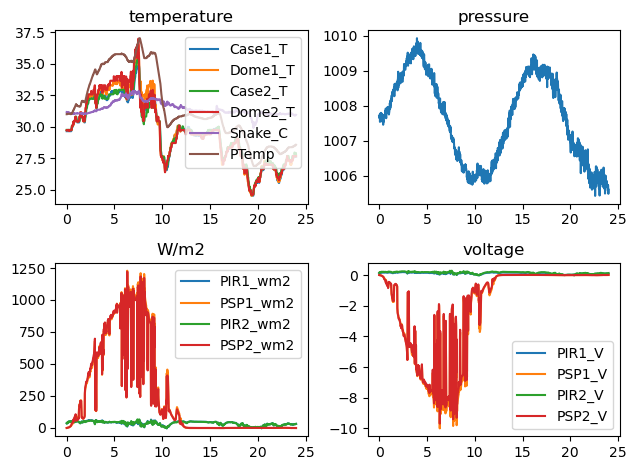

In [11]:
# read and plot an example day

mastdir = "./data/PSL/"
prefix = "me2"
dt = Date(2024,05,08) # for datestamp in filter(startswith("2024"), readdir(mastdir))
# get_das_pathfiles(prefix, dt)
pathfilenames = get_das_pathfiles(prefix, dt)
# filter(startswith("me2"), readdir(joinpath(mastdir, string(yday(dt)))))[1]
Me2day = read_das_dict(pathfilenames, me2keys)

Vkey = filter(x -> endswith(String(x), "_V")    , me2keys)
Tkey = filter(x -> endswith(String(x), r"_T|_C"), me2keys)
Wkey = filter(x -> endswith(String(x), "_wm2"  ), me2keys)

dh = decimal_hour.(Me2day[:time])
# quick plot 1 day
clf()
subplot(2,2,1)
for k in Tkey
    plot(m2n.(dh), m2n.(Me2day[k]))
end
plot(m2n.(dh), m2n.(Me2day[:PTemp]))
title("temperature")
legend((String.(Tkey)..., "PTemp"))

subplot(2,2,2)
plot(m2n.(dh), m2n.(Me2day[:BP_hpa]))
title("pressure")
# legend("BP_hpa")

subplot(2,2,3)
for k in Wkey
    plot(m2n.(dh), m2n.(Me2day[k]))
end
title("W/m2")
legend((String.(Wkey)))

subplot(2,2,4)
for k in Vkey
    plot(m2n.(dh), m2n.(Me2day[k]))
end
title("voltage")
legend((String.(Vkey)))

tight_layout()

In [42]:
yday(dt)

129